# GNN with explicit inter-molecular interactions

In [1]:
# Utilities
from tqdm.notebook import tqdm
# Scientific python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["text.usetex"] = False
import sklearn
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from torch_geometric.nn.pool import global_add_pool
from torch.utils.data import TensorDataset
from torch_geometric.utils import scatter
from torch_geometric.data import Batch
from torch.utils.data import Dataset
import random
# RDKit
import rdkit
from rdkit import Chem
import mordred
from mordred.Polarizability import APol, BPol
from mordred.TopoPSA import TopoPSA
from rdkit.Chem import rdMolDescriptors
print('Pytorch version:',torch.__version__)
print('Pytorch Geometric version:',torch_geometric.__version__)
print('RDKit version:', rdkit.__version__)
print('Mordred version:', mordred.__version__)
tqdm.pandas()

Pytorch version: 2.2.1+cpu
Pytorch Geometric version: 2.5.0
RDKit version: 2023.09.5
Mordred version: 1.2.0


In [2]:
# random seed for Python's random module
seed = 42
random.seed(seed)

# random seed for NumPy
np.random.seed(seed)

# random seed for PyTorch
torch.manual_seed(seed)

## Load data

In [3]:
df = pd.read_csv('data_cleaned_vis.csv', encoding='unicode_escape')
df.head()

,Type,No,HBA,Smiles_HBA,CAS_HBA,XHBA,HBD,Smiles_HBD,CAS_HBD,XHBD,Set,T/K,Viscosity,Log viscosity
0,I,1,Zinc chloride,Cl[Zn]Cl,7646-85-7,0.667,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.333,training,298.15,85000.0,11.35
1,II,2,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,293.15,13085.4,9.48
2,II,3,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,315.15,2475.7,7.81
3,II,4,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,326.15,1195.3,7.09
4,II,5,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,347.65,422.9,6.05


In [4]:
df['Set'].unique()

array(['training', 'test'], dtype=object)

## Add SMILES

In [22]:
df_hba = pd.read_csv('HBA_smiles_vis.csv')
df_hbd = pd.read_csv('HBD_smiles_vis.csv')
df_hba.head().set_index('Name')['SMILES']

Name
Acetamide                                                                   CC(=O)N
Acetylcholine chloride                                   CC(=O)OCC[N+](C)(C)C.[Cl-]
Allyltriphenylphosphonium bromide        C=CC[P+](c1ccccc1)(c1ccccc1)c1ccccc1.[Br-]
Ammonium thiocyanate                                               C(#N)[S-].[NH4+]
Atropine                             CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)C3=CC=CC=C3
Name: SMILES, dtype: object

In [6]:
df['HBA_SMILES'] = df['HBA'].map(df_hba.set_index('Name')['SMILES'])
df['HBD_SMILES'] = df['HBD'].map(df_hbd.set_index('Name')['SMILES'])
df.head()

,Type,No,HBA,Smiles_HBA,CAS_HBA,XHBA,HBD,Smiles_HBD,CAS_HBD,XHBD,Set,T/K,Viscosity,Log viscosity,HBA_SMILES,HBD_SMILES
0,I,1,Zinc chloride,Cl[Zn]Cl,7646-85-7,0.667,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.333,training,298.15,85000.0,11.35,Cl[Zn]Cl,C[N+](C)(C)CCO.[Cl-]
1,II,2,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,293.15,13085.4,9.48,O.O.O.O.O.O.Cl[Cr](Cl)Cl,C[N+](C)(C)CCO.[Cl-]
2,II,3,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,315.15,2475.7,7.81,O.O.O.O.O.O.Cl[Cr](Cl)Cl,C[N+](C)(C)CCO.[Cl-]
3,II,4,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,326.15,1195.3,7.09,O.O.O.O.O.O.Cl[Cr](Cl)Cl,C[N+](C)(C)CCO.[Cl-]
4,II,5,Chromic chloride hexahydrate,O.O.O.O.O.O.Cl[Cr](Cl)Cl,10060-12-5,0.500,Choline chloride,C[N+](C)(C)CCO.[Cl-],67-48-1,0.500,training,347.65,422.9,6.05,O.O.O.O.O.O.Cl[Cr](Cl)Cl,C[N+](C)(C)CCO.[Cl-]


## Create molecules

In [7]:
df['mol_hba'] = df['HBA_SMILES'].apply(Chem.MolFromSmiles)
df['mol_hbd'] = df['HBD_SMILES'].apply(Chem.MolFromSmiles)

## Compute molecular descriptors

### Atomic polarizability

In [8]:
ap_fun = APol()
df['ap_hba'] = df['mol_hba'].apply(ap_fun)
df['ap_hbd'] = df['mol_hbd'].apply(ap_fun)

### Bond polarizability

In [9]:
bp_fun = BPol()
df['bp_hba'] = df['mol_hba'].apply(bp_fun)
df['bp_hbd'] = df['mol_hbd'].apply(bp_fun)

### Topological polar surface area

In [10]:
topopsa_fun = TopoPSA()
df['topopsa_hba'] = df['mol_hba'].apply(topopsa_fun)
df['topopsa_hbd'] = df['mol_hbd'].apply(topopsa_fun)

### Intra-molecular hydrogen-bonding sites

In [11]:
def get_hb_sites(mol):
  return min(rdMolDescriptors.CalcNumHBA(mol), rdMolDescriptors.CalcNumHBD(mol))

df['hb_hba'] = df['mol_hba'].apply(get_hb_sites)
df['hb_hbd'] = df['mol_hbd'].apply(get_hb_sites)

### Inter-molecular hydrogen bonding sites

In [12]:
def get_inter_hb_sites(row):
    mol1 = row['mol_hba']
    mol2 = row['mol_hbd']
    return min(rdMolDescriptors.CalcNumHBA(mol1), rdMolDescriptors.CalcNumHBD(mol2)) + \
           min(rdMolDescriptors.CalcNumHBA(mol2), rdMolDescriptors.CalcNumHBD(mol1))


df['inter_hb'] = df.apply(get_inter_hb_sites, axis=1)

In [13]:
df['P (kPa)']  = 0

## Normalize data

In [18]:
train_df = df[df['Set'] == 'training'].copy()  #training', 'test
test_df = df[df['Set'] == 'test'].copy()

# Extract features and target
features = ['T/K', 'P (kPa)', 'XHBA', 'XHBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['Log viscosity'].values
X_test = test_df[features].values
y_test = test_df['Log viscosity'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

# Save standar scaler 
import joblib
joblib.dump(scaler, 'std_scaler_vis.bin', compress=True)
scaler.mean_
scaler.scale_

array([20.2802776 ,  1.        ,  0.21284922,  0.21284922, 18.11960594,
       10.16577375, 11.59672129,  6.90842319, 22.47534237, 23.90402476,
        0.52716493,  1.12789556,  0.95812602])

## Create graphs

In [52]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

### Atomic features

In [76]:
possible_atom_list = ['C','O','N','Cl','Br','P','Zn','Cr', 'S', 'F', 'K','Na']
possible_hybridization = [Chem.rdchem.HybridizationType.S,Chem.rdchem.HybridizationType.SP,Chem.rdchem.HybridizationType.SP2,Chem.rdchem.HybridizationType.SP3]
possible_num_bonds = [0,1,2,3,4]
possible_formal_charge = [0,1,-1]
possible_num_Hs  = [0,1,2,3, 4]

def atom_features(atom):
    '''
    Get atom features
    '''
    Symbol       = atom.GetSymbol()
    Type_atom     = one_of_k_encoding(Symbol, possible_atom_list)
    Ring_atom     = [atom.IsInRing()]
    Aromaticity   = [atom.GetIsAromatic()]
    Hybridization = one_of_k_encoding(atom.GetHybridization(), possible_hybridization)
    Bonds_atom    = one_of_k_encoding(len(atom.GetNeighbors()), possible_num_bonds)
    Formal_charge = one_of_k_encoding(atom.GetFormalCharge(), possible_formal_charge)
    num_Hs        = one_of_k_encoding(atom.GetTotalNumHs(), possible_num_Hs)

    results = Type_atom + Ring_atom + Aromaticity + Hybridization + Bonds_atom +  \
      Formal_charge + num_Hs
    return np.array(results).astype(np.float32)

### Bond features

In [61]:
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def bond_features(bond):
    bt = bond.GetBondType()
    # Features
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()]
    return np.array(bond_feats).astype(np.float32)

## Utilities

In [62]:
def n_atom_features():
    atom = Chem.MolFromSmiles('CC').GetAtomWithIdx(0)
    return len(atom_features(atom))

def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))

def sys2graph(df, mol_column_1, mol_column_2, target, single_system=False):
    """
    Constructs graph representations of binary molecular systems.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    mol_column_1 (str): Column name for the first component.
    mol_column_2 (str): Column name for the second component.
    target (str): Column name for the target variable.
    single_system (bool, optional): Whether to treat the dataframe as a single system.

    Returns:
    list: A list of graph objects.
    """
    def process_component(comp):
        """Processes a single component to extract edge attributes and indices."""
        edge_attr = []
        edge_index = get_bond_pair(comp)
        for bond in comp.GetBonds():
            edge_attr.extend([bond_features(bond)] * 2)
        return edge_attr, edge_index

    def info2graph(node_feat, edge_indx, edge_attr, y):
        """Creates graph for a component including the intra- and inter-molecular information"""
        nodes_info = torch.tensor(np.array(node_feat), dtype=torch.float32)
        edges_indx = torch.tensor(np.array(edge_indx), dtype=torch.long)
        edges_info = torch.tensor(np.array(edge_attr), dtype=torch.float32)
        graph = Data(x=nodes_info, edge_index=edges_indx, edge_attr=edges_info)
        graph.y = torch.tensor(y, dtype=torch.float)
        return graph

    def create_graph_indiv(c1, c2, y_val):
        """Helper function to create individual graphs."""
        atoms_c1 = c1.GetAtoms()
        atoms_c2 = c2.GetAtoms()
        node_features_c1 = [atom_features(atom) for atom in atoms_c1]
        node_features_c2 = [atom_features(atom) for atom in atoms_c2]

        edge_attr_c1, edge_index_c1 = process_component(c1)
        edge_attr_c2, edge_index_c2 = process_component(c2)

        # Info to graphs
        graph_c1 = info2graph(node_features_c1, edge_index_c1, edge_attr_c1, y_val)
        graph_c2 = info2graph(node_features_c2, edge_index_c2, edge_attr_c2, y_val)

        return graph_c1, graph_c2

    def create_graphs_from_row(row, mol_column_1, mol_column_2, target):
        graph_c1, graph_c2 = create_graph_indiv(row[mol_column_1], row[mol_column_2], row[target])

        # Append extra information to the graphs
        for graph in [graph_c1, graph_c2]:
            graph.Temp = row['T_norm']
            graph.P = row['P_norm']
            graph.mol_x = row['r_HBA_norm'] if graph == graph_c1 else row['r_HBD_norm']
            graph.ap = row['ap_hba_norm'] if graph == graph_c1 else row['ap_hbd_norm']
            graph.bp = row['bp_hba_norm'] if graph == graph_c1 else row['bp_hbd_norm']
            graph.topopsa = row['topopsa_hba_norm'] if graph == graph_c1 else row['topopsa_hbd_norm']
            graph.hb = row['hb_hba_norm'] if graph == graph_c1 else row['hb_hbd_norm']
            graph.inter_hb = row['inter_hb_norm']

        return graph_c1, graph_c2

    # Main function logic
    graphs_c1, graphs_c2 = zip(*df.apply(create_graphs_from_row, axis=1, args=(mol_column_1, mol_column_2, target)))
    return graphs_c1, graphs_c2

In [77]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'Log viscosity')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

## Graph Neural Network

In [78]:
class MPNNconv(nn.Module):
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats=32, num_step_message_passing=1):
        super(MPNNconv, self).__init__()

        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU()
        )

        self.num_step_message_passing = num_step_message_passing

        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(),
            nn.Linear(edge_hidden_feats, node_out_feats*node_out_feats)
        )
        self.gnn_layer = gnn.NNConv(
            node_out_feats,
            node_out_feats,
            edge_network,
            aggr='add'
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)

    def reset_parameters(self):
        self.project_node_feats[0].reset_parameters()
        self.gnn_layer.reset_parameters()
        for layer in self.gnn_layer.edge_func:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, system_graph):

        node_feats = system_graph.x
        edge_index = system_graph.edge_index
        edge_feats = system_graph.edge_attr
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            if torch.cuda.is_available():
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor).cuda(),
                                                   edge_index=edge_index.type(torch.LongTensor).cuda(),
                                                   edge_attr=edge_feats.type(torch.FloatTensor).cuda()))
            else:
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor),
                                                   edge_index=edge_index.type(torch.LongTensor),
                                                   edge_attr=edge_feats.type(torch.FloatTensor)))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)
        return node_feats

class EdgeModel(torch.nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in*2 + e_in + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.edge_mlp = nn.Sequential(*layers)

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr, u[batch]], axis=1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self, v_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.node_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0), reduce='sum')
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp(out)

class GlobalModel(torch.nn.Module):
    def __init__(self, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(hidden_dim + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.global_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        node_aggregate = scatter(x, batch, dim=0, reduce='sum')
        edge_aggregate = scatter(edge_attr, batch[edge_index[1]], dim=0, reduce='sum')
        out = torch.cat([u, node_aggregate, edge_aggregate], dim=1)
        return self.global_mlp(out)

class GHGNN(nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim, n_extra_inputs):
        super(GHGNN, self).__init__()
        self.graphnet1 = gnn.MetaLayer(EdgeModel(v_in, e_in, u_in, hidden_dim),
                                      NodeModel(v_in, u_in, hidden_dim),
                                      GlobalModel(u_in, hidden_dim))
        self.graphnet2 = gnn.MetaLayer(EdgeModel(hidden_dim, hidden_dim, hidden_dim, hidden_dim),
                                      NodeModel(hidden_dim, hidden_dim, hidden_dim),
                                      GlobalModel(hidden_dim, hidden_dim))

        self.gnorm1 = gnn.GraphNorm(hidden_dim)
        self.gnorm2 = gnn.GraphNorm(hidden_dim)

        self.pool = global_add_pool

        self.global_conv1 = MPNNconv(node_in_feats=hidden_dim*2,
                                     edge_in_feats=1,
                                     node_out_feats=hidden_dim*2)

        # MLP
        self.mlp1 = nn.Linear(hidden_dim*4 + n_extra_inputs, hidden_dim)
        self.mlp2 = nn.Linear(hidden_dim, hidden_dim)
        self.mlp3 = nn.Linear(hidden_dim, 1)

    def generate_sys_graph(self, x, edge_attr, batch_size, n_mols=2):

        src = np.arange(batch_size)
        dst = np.arange(batch_size, n_mols*batch_size)

        self_connection = np.arange(n_mols*batch_size)

        # Biderectional connections (between each molecule in the system)
        # and self-connection
        one_way = np.concatenate((src, dst, self_connection))
        other_way = np.concatenate((dst, src, self_connection))
        edge_index = torch.tensor([list(one_way),
                                   list(other_way)], dtype=torch.long)
        sys_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return sys_graph

    def forward(self, c1, c2):
        # ---- Atomic polarizability
        ap1 = c1.ap.reshape(-1,1)
        ap2 = c2.ap.reshape(-1,1)

        # ---- Bond polarizability
        bp1 = c1.bp.reshape(-1,1)
        bp2 = c2.bp.reshape(-1,1)

        # -- Polarity via topological polar surface area
        topopsa1 = c1.topopsa.reshape(-1,1)
        topopsa2 = c2.topopsa.reshape(-1,1)

        # -- Hydrogen-bond acidity and basicity
        intra_hb1 = c1.inter_hb
        intra_hb2 = c2.inter_hb

        u1 = torch.cat((ap1,bp1,topopsa1), axis=1) # Molecular descriptors molecule 1
        u2 = torch.cat((ap2,bp2,topopsa2), axis=1) # Molecular descriptors molecule 2

        # Molecule 1 GraphNet
        x1, edge_attr1, u1 = self.graphnet1(c1.x, c1.edge_index, c1.edge_attr, u1, c1.batch)
        x1 = self.gnorm1(x1, c1.batch)
        x1, edge_attr1, u1 = self.graphnet2(x1, c1.edge_index, edge_attr1, u1, c1.batch)
        x1 = self.gnorm2(x1, c1.batch)
        xg1 = self.pool(x1, c1.batch)

        # Molecule 2 GraphNet
        x2, edge_attr2, u2 = self.graphnet1(c2.x, c2.edge_index, c2.edge_attr, u2, c2.batch)
        x2 = self.gnorm1(x2, c2.batch)
        x2, edge_attr2, u2 = self.graphnet2(x2, c2.edge_index, edge_attr2, u2, c2.batch)
        x2 = self.gnorm2(x2, c2.batch)
        xg2 = self.pool(x2, c2.batch)

        batch_size = c1.y.shape[0]

        # Intermolecular descriptors
        # -- Hydrogen bonding
        inter_hb  = c1.inter_hb
        # Construct binary system graph
        node_feat = torch.cat((
            torch.cat((xg1, u1), axis=1),
            torch.cat((xg2, u2), axis=1)),axis=0)
        edge_feat = torch.cat((inter_hb.repeat(2),
                               intra_hb1,
                               intra_hb2)).unsqueeze(1)
        binary_sys_graph = self.generate_sys_graph(x=node_feat,
                                                   edge_attr=edge_feat,
                                                   batch_size=batch_size)
        xg = self.global_conv1(binary_sys_graph)


        xg = torch.cat((xg[0:len(xg)//2,:], xg[len(xg)//2:,:]), axis=1)

        T = torch.reshape(c1.Temp,(-1,1))
        P = torch.reshape(c2.P,(-1,1))
        x1 = torch.reshape(c1.mol_x,(-1,1))
        x2 = torch.reshape(c2.mol_x,(-1,1))

        ExtraVar = torch.cat((T,P,x1,x2),1)
        x = torch.cat((xg,ExtraVar),1)
        x = F.sigmoid(self.mlp1(x))
        x = F.sigmoid(self.mlp2(x))
        x = self.mlp3(x)
        return x

class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [79]:
class PairDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
    def __len__(self):
        return len(self.datasetA)

def collate(data_list):
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB

def get_dataloader_pairs(df, graphs_c1, graphs_c2, batch_size, shuffle=False, drop_last=False):

    g1s = df[graphs_c1].tolist()
    g2s  = df[graphs_c2].tolist()

    pair_dataset = PairDataset(g1s, g2s)
    data_loader  = torch.utils.data.DataLoader(pair_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, collate_fn=collate)

    return data_loader

In [80]:
train_df = df[df['Set'] == 'training']
test_df = df[df['Set'] == 'test']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

In [81]:
def train(model, device, dataloader, optimizer, loss_fn):
    """
    Trains the model.

    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for batch_c1, batch_c2 in dataloader:
        y =  batch_c1.y
        X1 = batch_c1
        X2 = batch_c2
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)

        # Model prediction and loss calculation
        y_hat = model(X1, X2)
        loss = loss_fn(y_hat, y.reshape(-1,1))
        loss_accum.update(loss.item(), y.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for batch_c1, batch_c2 in dataloader:
            y =  batch_c1.y
            X1 = batch_c1
            X2 = batch_c2
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)

            # Model prediction and loss calculation
            y_hat = model(X1, X2)
            loss = loss_fn(y_hat, y.reshape(-1,1))
            loss_accum.update(loss.item(), y.size(0))

    return loss_accum.avg

In [102]:
def parity_plots(y_train, y_train_hat, y_test, y_test_hat):

  metrics = [r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error]
  metric_names = ['R2', 'MAPE', 'MAE', 'RMSE']

  metrics_dict = {}
  for split, (y_true, y_pred) in zip(['train', 'test'], [(y_train, y_train_hat), (y_test, y_test_hat)]):
    metrics_dict[split] = {}
    for name, metric in zip(metric_names, metrics):
      metrics_dict[split][name] = metric(y_true, y_pred)

  metrics_train = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['train']['R2'],
      metrics_dict['train']['MAPE']*100,
      metrics_dict['train']['MAE'],
      metrics_dict['train']['RMSE']**0.5))

  metrics_test = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['test']['R2'],
      metrics_dict['test']['MAPE']*100,
      metrics_dict['test']['MAE'],
      metrics_dict['test']['RMSE']**0.5))

  fig , (ax1,ax2) = plt.subplots(1,2, figsize=(10.0 ,5.0))

  ax1.set_xlabel(r'$ln(\eta^{exp}_{DES}) $')
  ax1.set_ylabel(r'$ln(\eta^{pred}_{DES}) $')
  ax1.set_ylim([0,12])
  ax1.set_xlim([0,12])
  ax1.text(0.8,7, metrics_train, fontsize=10)
  ax1.grid(visible=True,which='major',linestyle = '--' ,linewidth = 0.5)
  ax1.scatter(y_train, y_train_hat, label='Training', marker='s', color='red')
  ax1.plot(np.linspace(0,12), np.linspace(0,12),linestyle = '--' , color  = 'black')
  ax1.legend(loc="best")

  ax2.set_xlabel(r'$ln(\eta^{exp}_{DES}) $')
  ax2.set_ylabel(r'$ln(\eta^{pred}_{DES}) $')
  ax2.set_ylim([0,12])
  ax2.set_xlim([0,12])
  ax2.text(0.8,7, metrics_test, fontsize=10)
  ax2.grid(visible=True,which='major', linestyle = '--' ,linewidth = 0.5)
  ax2.scatter(y_test, y_test_hat, label='Testing', marker='s', color='blue')
  ax2.plot(np.linspace(0,12),np.linspace(0,12),linestyle = '--' , color  = 'black')
  ax2.legend(loc="best")

### Training with tuned hyperparameterts

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)
epochs = 1000

In [84]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           'GNN_MG_vis.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

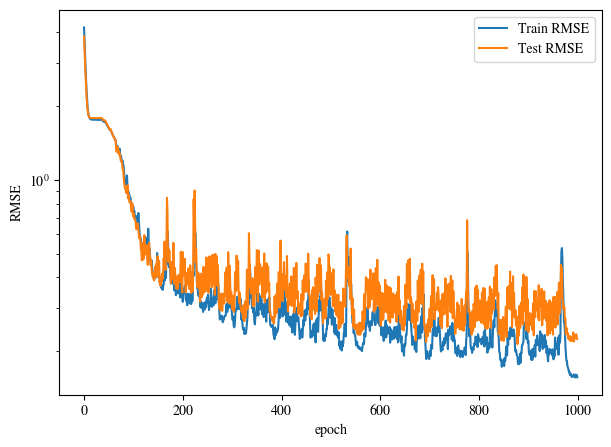

In [86]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [87]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load('GNN_MG_vis.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      #print(batch_c1,batch_c2)
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

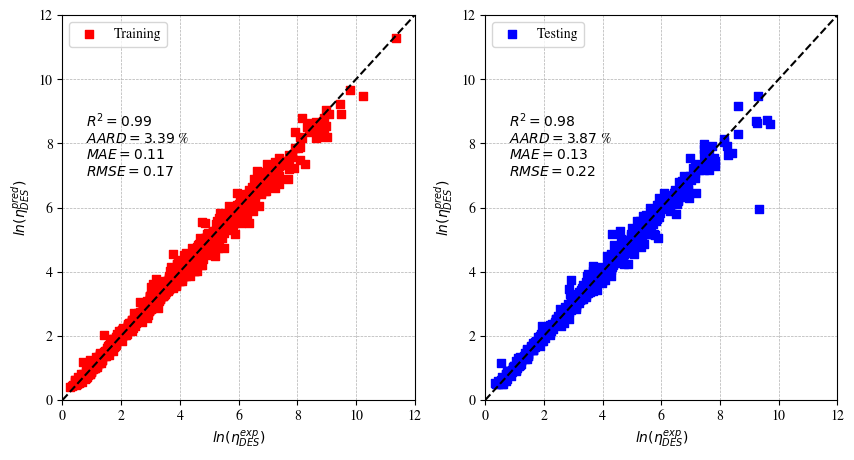

In [103]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

In [79]:
g1s = [train_df['g_hba'].iloc[0]]  #train_df['g_hba'].tolist()
g2s = [train_df['g_hbd'].iloc[0]]  #train_df['g_hbd'].tolist()
pair_dataset = PairDataset(g1s, g2s)
print(pair_dataset)
data_loader_test  = torch.utils.data.DataLoader(pair_dataset,  batch_size=1, shuffle=False, drop_last=False, collate_fn=collate) 
print(data_loader_test)

In [87]:
model.eval()
with torch.no_grad():
    for batch_x1, batch_x2 in data_loader_test:
        print( model(batch_x1, batch_x2 ).item() ) 

-5.318721294403076
